# LSTM Autoencoder

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
directory = '/teamspace/studios/this_studio/time-series-anomaly-detection'
if os.path.exists(directory):
    os.chdir(directory)

from data.dataset_utils import load_data, preprocess, Subjects, prepare_data, get_dataloader
from _3_autoencoder.plot import plot_losses_and_auc, plot_histogram
from _3_autoencoder.test import report, leave_one_subject_out_CV

import torch
import torch.nn as nn
from torch.nn import functional as F
from _3_autoencoder.models.base_autoencoder import BaseAutoencoder

## EDA

In [ ]:
df = load_data(filtered=True)
df = preprocess(df, emg_envelope=True, resample_length=2816/88) # 32

In [ ]:
batch_size = 32
mp_filter = 0.25

# for training
train_data_normal, _ = prepare_data(df, ['gsr'], classes=[0], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
train_loader_normal = get_dataloader(train_data_normal, batch_size=batch_size, shuffle=True)

# for validation
_, test_data = prepare_data(df, ['gsr'], classes=[0, 4], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
test_loader = get_dataloader(test_data, batch_size=batch_size, shuffle=False)

# for testing with training data
_, val_train_data = prepare_data(df, train_subjects=Subjects.val, test_subjects=Subjects.all, signals=['gsr'], classes=[0, 4], mp_filter=mp_filter)
val_train_loader = get_dataloader(val_train_data, batch_size=batch_size, shuffle=False)

In [221]:
class EDA_LSTM_AE(BaseAutoencoder):
    def build(self):
        self.enc_lstm = nn.LSTM(
            input_size=1,
            hidden_size=8,
            num_layers=1,
            batch_first=True,
            proj_size=1,
        )
    
        self.dec_lstm = nn.LSTM(
            input_size=1,
            hidden_size=8,
            num_layers=1,
            batch_first=True,
            proj_size=1,
        )
    
    def forward(self, x):
        batch_size, seq_len, channels = x.shape
        
        enc, (h_n, c_n) = self.enc_lstm(x)

        #c_n = c_n.reshape(1, batch_size, -1)
        h_0 = torch.zeros(1, batch_size, 1).to(self.device)

        #h_0 = torch.zeros_like(h_n).to(self.device)
        x_0 = torch.zeros_like(x).to(self.device)

        # using repeat vector
        #c_n = c_n.squeeze(0)
        #repeat_vector = c_n.unsqueeze(1).repeat(1, seq_len, 1)

        dec, _ = self.dec_lstm(x_0, (h_0, c_n)) 
        return dec

In [223]:
eda_lstm_ae = EDA_LSTM_AE(config={'crop_size':4})
train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores, evaluation = eda_lstm_ae.train_model(train_loader_normal, epochs=100, lr=1e-3, val_loader=test_loader)

Epoch 1/100 - Train loss: 1.0481 - Val loss normal: 0.7135 - Val loss anomaly: 0.9001 - Val AUC: 0.4852
Epoch 2/100 - Train loss: 1.0504 - Val loss normal: 0.7134 - Val loss anomaly: 0.8995 - Val AUC: 0.4850
Epoch 3/100 - Train loss: 1.0391 - Val loss normal: 0.7161 - Val loss anomaly: 0.9013 - Val AUC: 0.4842
Epoch 4/100 - Train loss: 1.0332 - Val loss normal: 0.7140 - Val loss anomaly: 0.8989 - Val AUC: 0.4841
Epoch 5/100 - Train loss: 1.0298 - Val loss normal: 0.7079 - Val loss anomaly: 0.8927 - Val AUC: 0.4843
Epoch 6/100 - Train loss: 1.0407 - Val loss normal: 0.7038 - Val loss anomaly: 0.8878 - Val AUC: 0.4837
Epoch 7/100 - Train loss: 1.0209 - Val loss normal: 0.7008 - Val loss anomaly: 0.8831 - Val AUC: 0.4821
Epoch 8/100 - Train loss: 0.9990 - Val loss normal: 0.6826 - Val loss anomaly: 0.8630 - Val AUC: 0.4807
Epoch 9/100 - Train loss: 0.9703 - Val loss normal: 0.6558 - Val loss anomaly: 0.8316 - Val AUC: 0.4776
Epoch 10/100 - Train loss: 0.9107 - Val loss normal: 0.5867 - Va

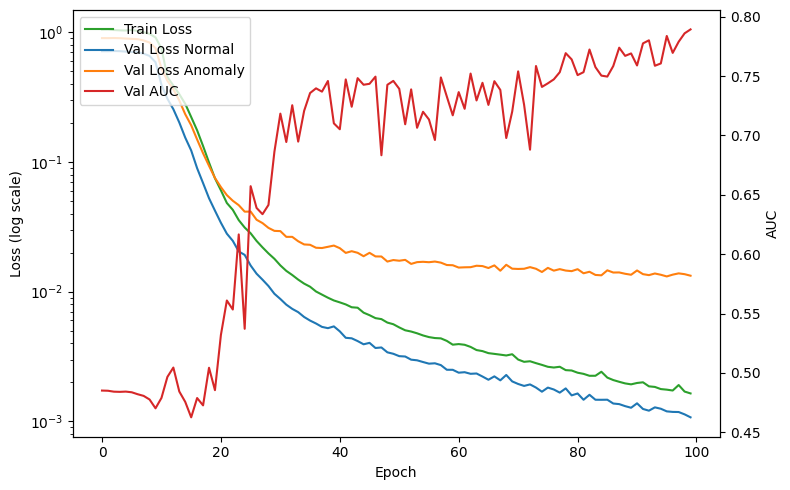

Best AUC: 0.7892 at epoch 100


In [224]:
plot_losses_and_auc(train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores)

Ground truth: 1
Reconstruction error: 0.0014577796682715416


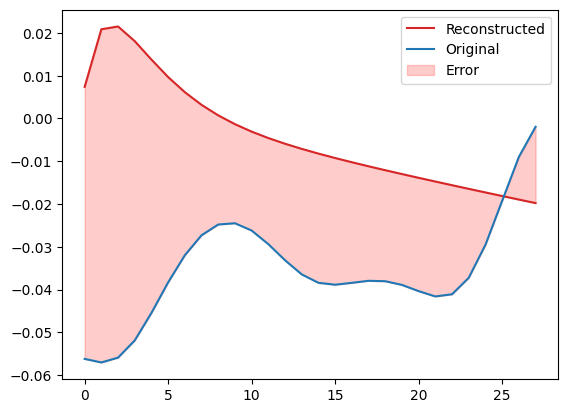

In [231]:
loader = get_dataloader(test_data, batch_size=1, shuffle=True)
signals, labels = next(iter(loader))
print(f'Ground truth: {int(labels[0].item())}')
eda_lstm_ae.plot_reconstruction(signals[0].unsqueeze(0))

In [ ]:
evals_train = eda_lstm_ae.evaluate_model(val_train_loader)
report([evaluation], [evals_train], percentile=80)

method       acc           prec            rec  \
                              NaN       avg  std       avg  std       avg   
0   test_supervised_acc_threshold  0.744231  0.0  0.799528  0.0  0.651923   
1  train_supervised_acc_threshold  0.744231  0.0  0.799528  0.0  0.651923   
2      fixed_percentile_threshold  0.709615  0.0  0.816860  0.0  0.540385   
3                mixmod_threshold  0.663462  0.0  0.863248  0.0  0.388462   
4                filter_threshold  0.516346  0.0  1.000000  0.0  0.032692   
5                 karch_threshold  0.544231  0.0  0.942308  0.0  0.094231   
6                    eb_threshold  0.500000  0.0  0.000000  0.0  0.000000   

             auc      threshold      percentile       
   std       avg  std       avg  std        avg  std  
0  0.0  0.789238  0.0  0.000340  0.0  83.461538  0.0  
1  0.0  0.789238  0.0  0.000340  0.0  71.436782  0.0  
2  0.0  0.789238  0.0  0.000668  0.0        NaN  NaN  
3  0.0  0.789238  0.0  0.002874  0.0        NaN  NaN  
4  0.0  0.789238  0.0  0.095615  0.0        NaN  NaN  
5  0.0  0.789238  0.0  0.029410  0.0        NaN  NaN  
6  0.0  0.789238  0.0  1.000000  0.0        NaN  NaN